## Import Libraries

In [2]:
>>> import nltk
>>> nltk.download('stopwords')
import pandas as pd
import json
import numpy as np
import re
from nltk.stem.porter import *
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
import torch
from torchtext import data
import random
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import time
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import spacy
lang = spacy.load('en')
stemmer = PorterStemmer()
import warnings
warnings.filterwarnings('ignore')
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("GPU Model   ",torch.cuda.get_device_name(0))
import six
import sys
sys.modules['sklearn.externals.six'] = six
from imblearn.over_sampling import RandomOverSampler

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
GPU Model    Tesla T4


## Confusion Matrix Method

In [3]:
def plot_confusion_matrix(cm, classes,
                          normalize=True,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    
    import itertools
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

## Cleaning Data, Preprocessing

In [4]:
def clean_data(X):
    STOPWORDS = set(stopwords.words('english'))
    X=X.str.lower()
    X=X.str.replace("[/(){}\[\]\|@,;]", " ")
    X=X.str.replace("[^0-9a-z #+_]", " ")
    X = X.str.replace(r'\d+','')
    X = X.apply(lambda x: ' '.join([w for w in str(x).split() if (len(w)>2 and w not in STOPWORDS) ] ))
    X = X.apply(lambda x: x.split()) 
    return X

def target_arrange(y):
    
    for i in range(len(y)):
        if y.values[i]=="Neutral":
            y.values[i]=0
        else:
            y.values[i]=1
            
    y=y.to_numpy()  
    y=y.reshape(y.shape[0],1)
    y= pd.DataFrame(data=y)
    y=np.ravel(y)
    y=y.astype('float')
    return y



## Load Dataset and Process

In [5]:
with open("Tech_news.json","r") as fp:
#with open("General_Market.json",encoding='utf8') as fp:
    json_d = json.load(fp)
 
ticks_d = json_d['data']
df = pd.DataFrame(ticks_d)

X= pd.DataFrame(columns=['Date', 'Article','Target'])
X['Date']=pd.to_datetime(df['date'])
X['Article']=df['title']+" "+df['text']
X['Target']=df['sentiment']

X=X.sort_values("Date")

print("Number of Examples : ",len(X),"\n")
X.drop_duplicates(inplace=True)
X.index = range(len(X))
print("Number of Examples after removing duplicates: ",len(X),"\n")

print('Number of words before cleaning : ',X['Article'].apply(lambda x: len(str(x).split(' '))).sum())
X['Article']=clean_data(X['Article'])
print('Number of words after cleaning : ',X['Article'].apply(lambda x: len(str(x).split(' '))).sum())
print("\n******************\n")

X['Target']=target_arrange(X['Target'])
X=X.drop('Date',1)

print("Neutral Examples : ",(X['Target']==0).sum())
print("Not Neutral Examples : ",(X['Target']==1).sum())


Number of Examples :  50637 

Number of Examples after removing duplicates:  40335 

Number of words before cleaning :  1605866
Number of words after cleaning :  1075700

******************

Neutral Examples :  20119
Not Neutral Examples :  20216


## Stemming

In [6]:
X['Article']= X['Article'].apply(lambda x: [stemmer.stem(i) for i in x]) # stemming
for i in range(len(X['Article'])): #φέρνω τα tokens ξανά μαζί διαχωριζόμενα με κενά
    X['Article'][i] = ' '.join(X['Article'][i])
print(X['Article'])
Xv = X['Article'].to_frame()

X_train,X_test,y_train,y_test = train_test_split(Xv,X['Target'], test_size=0.3,stratify=X['Target'])
X_train,X_val,y_train,y_val = train_test_split(X_train,y_train, test_size=0.2,stratify=y_train)

ros = RandomOverSampler()
X_train,y_train = ros.fit_resample(X_train, y_train)

train=pd.DataFrame(columns=['Article','Target'])
val = pd.DataFrame(columns=['Article','Target'])
test= pd.DataFrame(columns=['Article','Target'])


df = pd.DataFrame(data = X_train,columns=['Article'])
df1= pd.DataFrame(data = y_train,columns=['Target'])
train['Article']=df['Article']
train['Target']=df1['Target']
df = pd.DataFrame(data = X_test,columns=['Article'])
df1= pd.DataFrame(data = y_test,columns=['Target'])
test['Article']=df['Article']
test['Target']=df1['Target']
df = pd.DataFrame(data = X_val,columns=['Article'])
df1= pd.DataFrame(data = y_val,columns=['Target'])
val['Article']=df['Article']
val['Target']=df1['Target']

print("\n")
print("\nNeutral Examples in Training after OverSampling: ",(train['Target']==0).sum())
print("Not Neutral Examples in Training after OverSampling: ",(train['Target']==1).sum())


train.to_csv (r'Train_Tech.csv', index = False, header=True)
test.to_csv (r'Test_Tech.csv', index = False, header=True)
val.to_csv (r'Val_Tech.csv', index = False, header=True)


0        gtt commun gtt report loss lag revenu estim gt...
1        greenski get anoth downgrad even though damag ...
2        system ddd earn top revenu miss fall system dd...
3        angi homeservic stock plung toward year low ea...
4        match group stock get downgrad massiv ralli ma...
                               ...                        
40330    failur star war latest trilog teach invest pas...
40331    everyon talk disney stock busi hit hard effect...
40332    lockhe martin stock buy stock outperform past ...
40333    amazon drone amazon com inc nasdaq amzn use dr...
40334    geeli maker polestar plan new plant precept mo...
Name: Article, Length: 40335, dtype: object



Neutral Examples in Training after OverSampling:  11321
Not Neutral Examples in Training after OverSampling:  11321


## Build Vocabulary

In [7]:
torch.manual_seed(1234)
torch.backends.cudnn.deterministic = True

#TEXT = data.Field(tokenize='spacy',batch_first=True)
TEXT = data.Field(batch_first=True)
LABEL = data.LabelField(dtype = torch.float,batch_first=True)

fields = [('text',TEXT),('label', LABEL)]
X_train=data.TabularDataset(path = 'Train_Tech.csv',format = 'csv',fields = fields,skip_header = True)
X_test=data.TabularDataset(path = 'Test_Tech.csv',format = 'csv',fields = fields,skip_header = True)
X_val=data.TabularDataset(path = 'Val_Tech.csv',format = 'csv',fields = fields,skip_header = True)

TEXT.build_vocab(X_train)  
LABEL.build_vocab(X_train)

print("Size of TEXT vocabulary:",len(TEXT.vocab))

#No. of unique tokens in label
print("Size of LABEL vocabulary:",len(LABEL.vocab))

#Commonly used words
print(TEXT.vocab.freqs.most_common(10))  




Size of TEXT vocabulary: 21098
Size of LABEL vocabulary: 2
[('stock', 9582), ('compani', 6783), ('earn', 6588), ('inc', 6332), ('announc', 6077), ('busi', 4399), ('new', 4177), ('report', 4119), ('investor', 3894), ('today', 3661)]


## Accuracy, Loss and Optimizer Function

In [8]:
def find_accuracy(preds, y):
    real_values=torch.sigmoid(preds)
    temp = torch.round(real_values)
    valid = (temp == y).float() 
    accur = valid.sum() / len(valid)
    return accur,temp,y,real_values

def Loss_Optimizer (model,valueLR):
    criterion = nn.BCEWithLogitsLoss()
    #criterion = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=valueLR)
    return optimizer,criterion

## Training and Testing Functions 

In [9]:
def train(model,data,lr,optimizer,criterion):
        
    model.train()
    sumloss=0.0
    sumacc=0.0
    for i in data:
        text = i.text   
        optimizer.zero_grad()
        pred = model(text).squeeze(1)    
        loss = criterion(pred, i.label)
        acc,_,_,_ = find_accuracy(pred, i.label)
        loss.backward()
        optimizer.step()
        sumloss += loss.item()
        sumacc += acc.item()
          
    return sumloss / len(data), sumacc / len(data)

def test(model, data, criterion):
    y_pred_list = []
    y_true_list = []
    real_v_list = []
    sumloss = 0
    sumacc = 0
    
    model.eval()
    
    with torch.no_grad():
    
        for i in data:
            text = i.text
            
            pred = model(text).squeeze(1)
           
            loss = criterion(pred, i.label)
            
            acc,y_pred_tags,y_true,real_v = find_accuracy(pred, i.label)

            sumloss += loss.item()
            sumacc += acc.item()
            y_pred_list.append(y_pred_tags.cpu().numpy())
            y_true_list.append(y_true.cpu().numpy())
            real_v_list+=real_v.flatten().tolist()
        
    return sumloss / len(data), sumacc / len(data),y_pred_list,y_true_list,real_v_list

def process_test(model,numEpochs,data_tr,data_val,data_test,lr,best_model):

    optimizer,criterion=Loss_Optimizer (model,lr)
    criterion = criterion.to(device)
    start_time = time.time()
    
    for i in range(numEpochs):
 
        train_loss, train_acc = train(model, data_tr, lr,optimizer,criterion)
        valid_loss, valid_acc,_,_ ,_= test(model, data_val, criterion)
        
        if i==0:
            max=valid_acc
            torch.save(model.state_dict(), best_model)
        elif valid_acc > max:
            max = valid_acc
            torch.save(model.state_dict(), best_model)

        if (i+1)%5==0:
          print("Epoch : ",i+1," Train Loss : ",train_loss,"  Train Acc : ",train_acc,"  Valid Loss : ",valid_loss, " Val Acc : ",valid_acc)
    
    end_time = time.time()
    timeHelp=(end_time-start_time)/60.0
    print("\nTime needed for Training : ",timeHelp)

    
    
   
    model.load_state_dict(torch.load(best_model))
    
    test_loss, test_acc,y_pred_list,y_true_list, real_v_list= test(model, data_test, criterion)
    print("\nLoss in Testset : ",test_loss,"  Accuracy in Testset : ",test_acc,"\n")

    y_pred_list = [a.squeeze().tolist() for a in y_pred_list]
    y_true_list = [a.squeeze().tolist() for a in y_true_list]
    
    yp = [item for sublist in y_pred_list for item in sublist]
    yt = [item for sublist in y_true_list for item in sublist]
    
    cnf_matrix = confusion_matrix(yt, yp,labels=[0, 1])
    np.set_printoptions(precision=3)

    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=[0, 1],
                      title='Confusion matrix, with normalization')
     
    return real_v_list

def process_test2(model,numEpochs,data_tr,data_val,data_test,lr,best_model):

    optimizer,criterion=Loss_Optimizer (model,lr)
    criterion = criterion.to(device)
    start_time = time.time()
        
    for i in range(numEpochs):
 
        train_loss, train_acc = train(model, data_tr, lr,optimizer,criterion)
        valid_loss, valid_acc,_,_,_ = test(model, data_val, criterion)
        
        if i==0:
            minloss=valid_loss
            torch.save(model.state_dict(), best_model)
        elif valid_loss < minloss:
            minloss = valid_loss
            torch.save(model.state_dict(), best_model)

        if (i+1)%5==0:
          print("Epoch : ",i+1," Train Loss : ",train_loss,"  Train Acc : ",train_acc,"  Valid Loss : ",valid_loss, " Val Acc : ",valid_acc)
    
    end_time = time.time()
    timeHelp=(end_time-start_time)/60.0
    print("\nTime needed for Training : ",timeHelp)

    model.load_state_dict(torch.load(best_model))
    
    test_loss, test_acc,y_pred_list,y_true_list, real_v_list= test(model, data_test, criterion)
    print("\nLoss in Testset : ",test_loss,"  Accuracy in Testset : ",test_acc,"\n")

    y_pred_list = [a.squeeze().tolist() for a in y_pred_list]
    y_true_list = [a.squeeze().tolist() for a in y_true_list]
    
    yp = [item for sublist in y_pred_list for item in sublist]
    yt = [item for sublist in y_true_list for item in sublist]
    
    cnf_matrix = confusion_matrix(yt, yp,labels=[0, 1])
    np.set_printoptions(precision=3)

    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=[0, 1],
                      title='Confusion matrix, with normalization')
    return real_v_list

## RNN Models

In [10]:
class myLSTM(nn.Module):
    def __init__(self, voc, embed_d, hid_d, out_d,dropout):
        
        super().__init__()
        
        self.embedding = nn.Embedding(voc, embed_d)
        self.rnn = nn.LSTM(embed_d,hid_d,batch_first=True,num_layers=2,bidirectional=True,dropout=dropout)
        self.fc = nn.Linear(hid_d * 2, out_d)
        self.dropout = nn.Dropout(dropout)
    def forward(self, input_text):
                
        embedded = self.dropout(self.embedding(input_text))
       
        rnn_out,(rnn_hid,rnn_cell) = self.rnn(embedded)
        hidden = self.dropout(torch.cat((rnn_hid[-2,:,:], rnn_hid[-1,:,:]), dim=1))
        out=self.fc(hidden.squeeze(0))
        return out

class myGRU(nn.Module):
    def __init__(self, voc, embed_d, hid_d, out_d,dropout):
        
        super().__init__()
        
        self.embedding = nn.Embedding(voc, embed_d)
        self.rnn = nn.GRU(embed_d,hid_d,batch_first=True,num_layers=2,bidirectional=True,dropout=dropout)
        self.fc = nn.Linear(hid_d * 2, out_d)
        self.dropout = nn.Dropout(dropout)
    def forward(self, input_text):
                
        embedded = self.dropout(self.embedding(input_text))
        
        rnn_out,hidden = self.rnn(embedded)
        hidden = self.dropout(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1))
        out=self.fc(hidden.squeeze(0))
        return out

In [11]:
myInput = len(TEXT.vocab)
myEmbed = 300
myHid = 256
myOut = 1
batch=1024
train_it, val_it, test_it = data.BucketIterator.splits((X_train, X_val, X_test),sort_key = lambda x: len(x.text),
    sort_within_batch=True,batch_size = batch,device = device)  
dropout = 0.5

new_model2 = myLSTM(myInput, myEmbed, myHid, myOut,dropout)
new_model2.to(torch.device(device))
new_model3 = myGRU(myInput, myEmbed, myHid, myOut,dropout)
new_model3.to(torch.device(device))

print(new_model2)
print(new_model3)
#torch.save(new_model2.state_dict(), 'model_LSTM_1.pt')

myLSTM(
  (embedding): Embedding(21098, 300)
  (rnn): LSTM(300, 256, num_layers=2, batch_first=True, dropout=0.5, bidirectional=True)
  (fc): Linear(in_features=512, out_features=1, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)
myGRU(
  (embedding): Embedding(21098, 300)
  (rnn): GRU(300, 256, num_layers=2, batch_first=True, dropout=0.5, bidirectional=True)
  (fc): Linear(in_features=512, out_features=1, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)


## Test LSTM

Epoch :  5  Train Loss :  0.250383151463567   Train Acc :  0.8920261548913043   Valid Loss :  0.28066922972599667  Val Acc :  0.8798868258794149
Epoch :  10  Train Loss :  0.16554515017196536   Train Acc :  0.9316830842391305   Valid Loss :  0.33595971763134  Val Acc :  0.8990184366703033
Epoch :  15  Train Loss :  0.11011454187657523   Train Acc :  0.9554177989130435   Valid Loss :  0.41878683120012283  Val Acc :  0.8985672096411387
Epoch :  20  Train Loss :  0.08225678625445731   Train Acc :  0.9678583559782609   Valid Loss :  0.46820200979709625  Val Acc :  0.9006738364696503
Epoch :  25  Train Loss :  0.058006392537525084   Train Acc :  0.9780061141304348   Valid Loss :  0.5525800647834936  Val Acc :  0.8984415133794149
Epoch :  30  Train Loss :  0.048228807042990054   Train Acc :  0.9821246603260869   Valid Loss :  0.6188456937670708  Val Acc :  0.8912893235683441

Time needed for Training :  2.5404158274332684

Loss in Testset :  0.5723147361228863   Accuracy in Testset :  0.8961

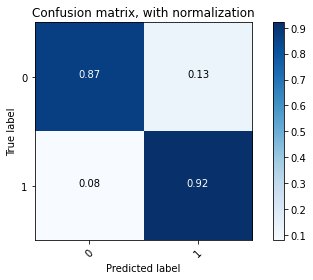

In [12]:
lstm_list=process_test(new_model2,30,train_it,val_it,test_it,0.001,"LSTM_Tech_1.pt")

## Test GRU

Epoch :  5  Train Loss :  0.2650349205258586   Train Acc :  0.8859969429347826   Valid Loss :  0.294662540157636  Val Acc :  0.8825187881787618
Epoch :  10  Train Loss :  0.18395376468391117   Train Acc :  0.9244650135869565   Valid Loss :  0.3112149511774381  Val Acc :  0.8954655031363169
Epoch :  15  Train Loss :  0.13664612688033073   Train Acc :  0.9440811820652174   Valid Loss :  0.37826328352093697  Val Acc :  0.9024364054203033
Epoch :  20  Train Loss :  0.10171635317332718   Train Acc :  0.9594089673913043   Valid Loss :  0.42366259048382443  Val Acc :  0.9009622931480408
Epoch :  25  Train Loss :  0.07422598304876137   Train Acc :  0.9708729619565217   Valid Loss :  0.4948130088547866  Val Acc :  0.9022921721140543
Epoch :  30  Train Loss :  0.058533755843229854   Train Acc :  0.978515625   Valid Loss :  0.5139056233068308  Val Acc :  0.901334136724472

Time needed for Training :  2.065715491771698

Loss in Testset :  0.4076216413329045   Accuracy in Testset :  0.8941866705814

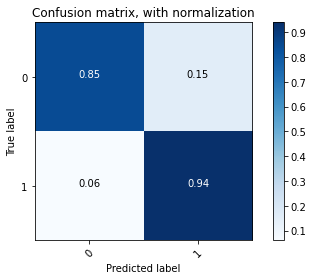

In [13]:
gru_list=process_test(new_model3,30,train_it,val_it,test_it,0.001,"GRU_Tech_1.pt")

## Testing Function for individual text

In [14]:
def sentence(model, s):
    model.eval()
    
    token = [tok.text for tok in lang.tokenizer(s)]
    index = [TEXT.vocab.stoi[t] for t in token]
    tensor = torch.LongTensor(index).to(device)
    tensor = tensor.unsqueeze(0)
    pred = torch.sigmoid(model(tensor))
    return pred.item()


## Evaluate Neutrals (maybe some of them are not)

In [15]:
Neutral_pd=X[X['Target'] == 0.0]
Neutral_pd.index = range(len(Neutral_pd))
v_list=[]
for index, row in Neutral_pd.iterrows():
    v=sentence(new_model3,Neutral_pd['Article'][index])
    v_list.append(v)
    if v>0.7:
      Neutral_pd['Target'][index]=1.0
    else:
      Neutral_pd['Target'][index]=0.0
Neutral_pd=Neutral_pd[Neutral_pd['Target'] == 1.0] 

print("Number of Neutrals than maybe are not : " ,len(Neutral_pd), " from GRU")

Neutral_pd2=X[X['Target'] == 0.0]
Neutral_pd2.index = range(len(Neutral_pd2))

v_list2=[]
for index, row in Neutral_pd2.iterrows():
    v=sentence(new_model2,Neutral_pd2['Article'][index])
    v_list2.append(v)
    if v>0.7:
      Neutral_pd2['Target'][index]=1.0
    else:
      Neutral_pd2['Target'][index]=0.0
Neutral_pd2=Neutral_pd2[Neutral_pd2['Target'] == 1.0] 

print("Number of Neutrals than maybe are not : " ,len(Neutral_pd2), " from LSTM")

# Combine 2 results from GRU and LSTM

Neutral_pd=Neutral_pd.merge(Neutral_pd2)

print("\nNumber of Neutrals that might be not Neutrals that agree LSTM and GRU : ",len(Neutral_pd))

Neutral_pd.index = range(len(Neutral_pd))

Neutral_pd.to_csv (r'new_Neutral_Tech.csv', index = False, header=True)

Number of Neutrals than maybe are not :  1468  from GRU
Number of Neutrals than maybe are not :  1063  from LSTM

Number of Neutrals that might be not Neutrals that agree LSTM and GRU :  885


## Plot the distribution of Neutrals

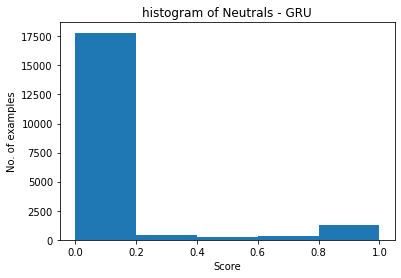

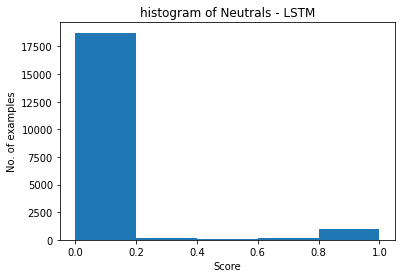

In [16]:
fig,ax = plt.subplots(1,1)

ax.hist(v_list, bins = [0,0.2,0.4,0.6,0.8,1])
ax.set_title("histogram of Neutrals - GRU")
ax.set_xticks([0,0.2,0.4,0.6,0.8,1])
ax.set_xlabel('Score')
ax.set_ylabel('No. of examples')
plt.show()

fig,ax = plt.subplots(1,1)

ax.hist(v_list2, bins = [0,0.2,0.4,0.6,0.8,1])
ax.set_title("histogram of Neutrals - LSTM")
ax.set_xticks([0,0.2,0.4,0.6,0.8,1])
ax.set_xlabel('Score')
ax.set_ylabel('No. of examples')
plt.show()